In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
df = pd.read_excel('Data_forecast_covid2021.xlsx')

In [3]:
df = df[['Tanggal','POSITIF']]

In [4]:
df = df.groupby('Tanggal', sort=False, as_index=True).agg(sum)
df

,POSITIF
Tanggal,
01-01-2021,185691
02-01-2021,187586
03-01-2021,189243
04-01-2021,191075
05-01-2021,192899
...,...
27-12-2021,865034
28-12-2021,865130
29-12-2021,865157


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(df[:292])
test_data = scaler.fit_transform(df[292:])

In [6]:
df.head()

,POSITIF
Tanggal,
01-01-2021,185691
02-01-2021,187586
03-01-2021,189243
04-01-2021,191075
05-01-2021,192899


In [7]:
train_data[:5]

array([[0.        ],
       [0.00280879],
       [0.00526482],
       [0.00798023],
       [0.01068379]])

In [8]:
scaler.inverse_transform(train_data[:5])

array([[860461.        ],
       [860474.58332333],
       [860486.46066726],
       [860499.59240781],
       [860512.66680451]])

In [9]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (292, 1)
Shape of test data: (73, 1)


In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [12]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (288, 3)
Shape of train labels: (288,)
Shape of test input: (69, 3)
Shape of test labels: (69,)


In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (288, 1, 3)
Shape of train labels: (288,)
Shape of test input: (69, 1, 3)
Shape of test labels: (69,)


In [15]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
288/288 - 4s - loss: 0.1731 - 4s/epoch - 15ms/step
Epoch 2/100
288/288 - 1s - loss: 0.0204 - 808ms/epoch - 3ms/step
Epoch 3/100
288/288 - 1s - loss: 0.0054 - 771ms/epoch - 3ms/step
Epoch 4/100
288/288 - 1s - loss: 5.8410e-04 - 764ms/epoch - 3ms/step
Epoch 5/100
288/288 - 1s - loss: 2.2152e-04 - 762ms/epoch - 3ms/step
Epoch 6/100
288/288 - 1s - loss: 1.6521e-04 - 756ms/epoch - 3ms/step
Epoch 7/100
288/288 - 1s - loss: 1.1562e-04 - 760ms/epoch - 3ms/step
Epoch 8/100
288/288 - 1s - loss: 7.6286e-05 - 755ms/epoch - 3ms/step
Epoch 9/100
288/288 - 1s - loss: 4.5475e-05 - 756ms/epoch - 3ms/step
Epoch 10/100
288/288 - 1s - loss: 3.0491e-05 - 755ms/epoch - 3ms/step
Epoch 11/100
288/288 - 1s - loss: 2.4250e-05 - 755ms/epoch - 3ms/step
Epoch 12/100
288/288 - 1s - loss: 2.1244e-05 - 754ms/epoch - 3ms/step
Epoch 13/100
288/288 - 1s - loss: 2.0901e-05 - 757ms/epoch - 3ms/step
Epoch 14/100
288/288 - 1s - loss: 1.9656e-05 - 754ms/epoch - 3ms/step
Epoch 15/100
288/288 - 1s - loss: 2.0232e-0

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 1s 4ms/step


In [18]:
testPredict[:5]

array([[0.03676397],
       [0.05425803],
       [0.07552443],
       [0.09562904],
       [0.10924542]], dtype=float32)

In [19]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
y_pred_test_lstm = model.predict(testX)
y_train_pred_lstm = model.predict(trainX)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(trainY[0], trainPredict[:,0])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(testY[0], testPredict[:,0])))

9/9 [==============================] - 0s 4ms/step
The R2 score on the Train set is:	1.000
The R2 score on the Test set is:	0.995


In [21]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.16 RMSE
Test Score: 88.56 RMSE


In [22]:
dates = pd.date_range(start='2021-03-01 00:00:00', end='2021-12-31 00:00:00', periods=trainY.shape[1])
dates

DatetimeIndex([          '2021-03-01 00:00:00',
               '2021-03-02 01:30:18.815331010',
               '2021-03-03 03:00:37.630662020',
               '2021-03-04 04:30:56.445993031',
               '2021-03-05 06:01:15.261324041',
               '2021-03-06 07:31:34.076655052',
               '2021-03-07 09:01:52.891986062',
               '2021-03-08 10:32:11.707317073',
               '2021-03-09 12:02:30.522648083',
               '2021-03-10 13:32:49.337979094',
               ...
               '2021-12-21 10:27:10.662020904',
               '2021-12-22 11:57:29.477351916',
               '2021-12-23 13:27:48.292682928',
               '2021-12-24 14:58:07.108013936',
               '2021-12-25 16:28:25.923344948',
               '2021-12-26 17:58:44.738675960',
               '2021-12-27 19:29:03.554006968',
               '2021-12-28 20:59:22.369337980',
               '2021-12-29 22:29:41.184668988',
                         '2021-12-31 00:00:00'],
              dtype=

In [23]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

In [24]:
trainActual

,Precipitation
2021-03-01 00:00:00.000000000,860499.592408
2021-03-02 01:30:18.815331010,860512.666805
2021-03-03 03:00:37.630662020,860529.884294
2021-03-04 04:30:56.445993031,860547.073112
2021-03-05 06:01:15.261324041,860568.283166
...,...
2021-12-26 17:58:44.738675960,865292.541516
2021-12-27 19:29:03.554006968,865293.430346
2021-12-28 20:59:22.369337980,865294.534215
2021-12-29 22:29:41.184668988,865295.473220


In [25]:
trainPredictdf

,Precipitation
2021-03-01 00:00:00.000000000,860561.6250
2021-03-02 01:30:18.815331010,860572.2500
2021-03-03 03:00:37.630662020,860583.0000
2021-03-04 04:30:56.445993031,860595.5000
2021-03-05 06:01:15.261324041,860609.2500
...,...
2021-12-26 17:58:44.738675960,865266.1250
2021-12-27 19:29:03.554006968,865267.1250
2021-12-28 20:59:22.369337980,865267.9375
2021-12-29 22:29:41.184668988,865268.7500


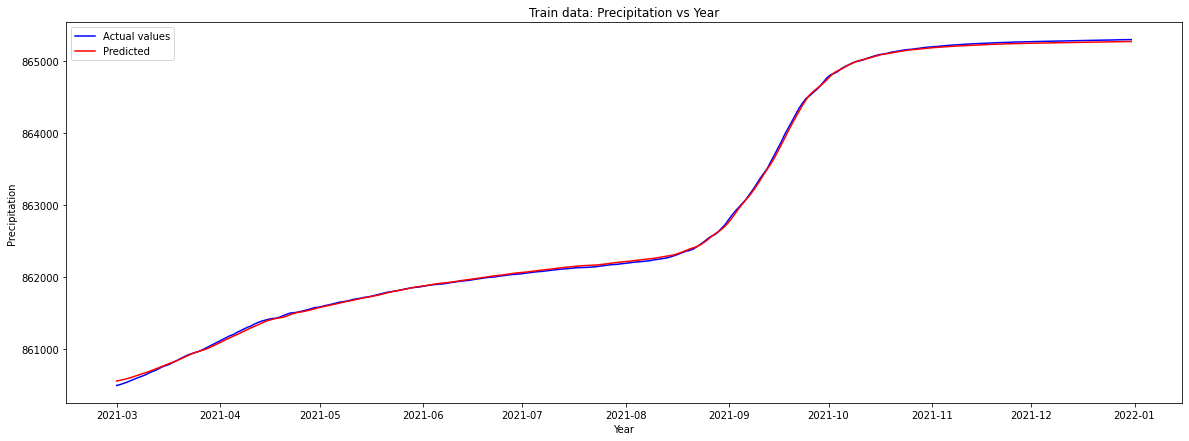

In [26]:
plt.figure(figsize=(20,7))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.legend(loc='best')
plt.savefig('LSTMCov2021.jpg',  dpi=300, bbox_inches='tight')